In [ ]:
!pip install tensorflow-io[tensorflow]

In [ ]:
!pip install nlpaug

In [ ]:
!pip install cmapy

## Importing Dependencies

In [272]:
import os
import random
import cv2
import cmapy
import pandas as pd
import numpy as np
import librosa as lb
import librosa.display as lbd
import matplotlib.pyplot as plt
from IPython.display import Audio
from random import uniform

#augmentation
import tensorflow_io as tfio
import nlpaug.augmenter.audio as naa

#train_test_val split
from sklearn.model_selection import train_test_split

## Loading Data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/hack/csv_data/processed.csv')
df.head()

,start,end,pid,mode,filename,disease,crack_wheeze
0,1.862,5.718,160,mc,160_1b3_Al_mc_AKGC417L_0.wav,COPD,2
1,5.718,9.725,160,mc,160_1b3_Al_mc_AKGC417L_1.wav,COPD,3
2,9.725,13.614,160,mc,160_1b3_Al_mc_AKGC417L_2.wav,COPD,2
3,13.614,17.671,160,mc,160_1b3_Al_mc_AKGC417L_3.wav,COPD,2
4,17.671,19.541,160,mc,160_1b3_Al_mc_AKGC417L_4.wav,COPD,0


In [4]:
#dupli-padded 7sec .wav file
wav_root = '/content/drive/MyDrive/hack/duplicated_7sec/'
#dupli-padded 7sec numpy file
np_root = '/content/drive/MyDrive/hack/duplicated_audio_7sec.npy'

In [5]:
np_data = np.load(np_root)
np_data[0]

array([-0.3642477 , -0.4573325 , -0.4095523 , ..., -0.17502756,
       -0.17589419, -0.17564602], dtype=float32)

## Train_Test_Split

stratify 를 사용하여 train 과 test set의 class 분포 비율 맞추기

In [6]:
x_train, x_test, y_train, y_test = train_test_split(np_data, df.crack_wheeze, stratify=df['crack_wheeze'], random_state=42, test_size=0.2)

In [7]:
print('All:', np.bincount(df.crack_wheeze) / float(len(df.crack_wheeze)) * 100.0)
print('Train set:', np.bincount(y_train) / float(len(y_train)) * 100.0)
print('Test set:', np.bincount(y_test) / float(len(y_test)) * 100.0)

All: [52.79791244 27.02232531 12.8443027   7.33545955]
Train set: [52.79086626 27.02065966 12.84885828  7.3396158 ]
Test set: [52.82608696 27.02898551 12.82608696  7.31884058]


In [11]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, stratify=y_test, random_state=42, test_size=0.5)

In [12]:
print('Validation set:', np.bincount(y_val) / float(len(y_val)) * 100.0)
print('Test set:', np.bincount(y_test) / float(len(y_test)) * 100.0)

Validation set: [50.72463768 27.24637681 14.20289855  7.82608696]
Test set: [51.01449275 27.24637681 13.91304348  7.82608696]


In [42]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

## Augmentation

In [45]:
sr=16000

#### Shift augmentation

In [68]:
def shift_aug(signal, sr=sr):
    aug = naa.ShiftAug(sampling_rate=sr, duration=uniform(1.5, 3.5))
    return aug.augment(signal)

#### Speed augmentation

In [69]:
def speed_aug(signal, sr=sr):
    aug = naa.SpeedAug(zone=(0.2, 0.8), coverage=0.5, factor=(0.5, 1), stateless=True)
    return aug.augment(signal)

#### Slicing

In [70]:
def audio_slice(signal, max=7*sr):
    if len(signal) > max:
        return signal[:max]
    else:
        return signal

#### Applying augmentation

In [102]:
def pre_aug(signal, label, sr=sr):
    prob = np.random.randint(0,2)
    if prob == 0:
        return shift_aug(signal), label
    else:
        aug = speed_aug(signal)
        return audio_slice(aug), label

#### Augmentation test

In [106]:
test_arr = []
for idx in range(3):
    test = pre_aug(x_train[idx], y_train[idx], sr=sr)
    test_arr.append(test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


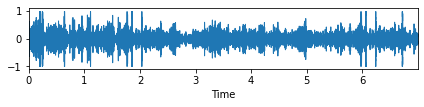

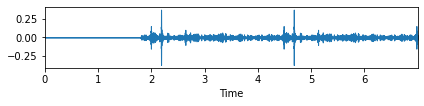

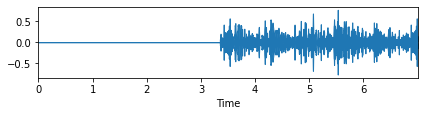

In [107]:
for idx in range(len(test_arr)):
    plt.subplot(3, 1, idx+1)
    lbd.waveplot(np.array(test_arr)[idx][0], sr=sr)
    plt.tight_layout()
    plt.show()

#### Applying to x_train dataset

In [108]:
aug_arr = []
for idx in range(len(x_train)):
    augmented = pre_aug(x_train[idx], y_train[idx], sr=sr)
    aug_arr.append(augmented)

In [355]:
import pickle

In [356]:
os.mkdir('/content/drive/MyDrive/hack/augmented_dataset')

In [357]:
with open('/content/drive/MyDrive/hack/augmented_dataset/augmented_data.pkl', 'wb') as f:
    pickle.dump(aug_arr, f)

In [109]:
np.save('/content/drive/MyDrive/hack/augmented_data.npy', aug_arr)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


#### New train set
original dataset + augmented dataset

In [269]:
len(aug_arr[0][0])

112000

In [354]:
type(aug_arr)

list

## Mel feature extraction & Blank region clipping

In [274]:
n_mels = 128
f_min = 100
f_max = 16000
nfft = 2048
hop = nfft//4

In [275]:
#mel feature extraction
def create_mel_raw(current_window, sr, n_mels=128, f_min=100, f_max=16000, nfft=2048, hop=512, resz=1):
    S = lb.feature.melspectrogram(y=current_window, sr=sr, n_mels=n_mels, fmin=f_min, fmax=f_max, n_fft=nfft, hop_length=hop)
    S = lb.power_to_db(S, ref=np.max)
    S = (S-S.min()) / (S.max() - S.min())
    S *= 255
    img = cv2.applyColorMap(S.astype(np.uint8), cmapy.cmap('magma'))
    height, width, _ = img.shape
    if resz > 0:
        img = cv2.resize(img, (width*resz, height*resz), interpolation=cv2.INTER_LINEAR) #bicubic interpolation
    img = cv2.flip(img, 0)
    return img

In [295]:
#blank region clipping
blank_clipped_aug = []
for idx in range(len(x_train)):
    audio_image = cv2.cvtColor(create_mel_raw(np.array(aug_arr)[idx][0], sr, n_mels, f_min, f_max, nfft, hop, resz=3), cv2.COLOR_BGR2RGB)
    audio_raw_gray = cv2.cvtColor(create_mel_raw(np.array(aug_arr)[idx][0], sr, n_mels, f_min, f_max, nfft, hop), cv2.COLOR_BGR2GRAY)

    audio_raw_gray[audio_raw_gray < 10] = 0
    for row in range(audio_raw_gray.shape[0]):
        black_percent = len(np.where(audio_raw_gray[row,:]==0)[0])/len(audio_raw_gray[row,:])
        if black_percent < 0.80:
            break

    if (row+1)*3 < audio_image.shape[0]:
        audio_image = audio_image[(row+1)*3:, :, :]
    audio_image = cv2.resize(audio_image, (audio_image.shape[1], n_mels*3), interpolation=cv2.INTER_LINEAR)
    audio_image, _, __ = cv2.split(audio_image)
    audio_image = cv2.resize(audio_image, (219, 128), interpolation=cv2.INTER_LINEAR)
    audio_image = np.array(audio_image, dtype=float)

    blank_clipped_aug.append(audio_image)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


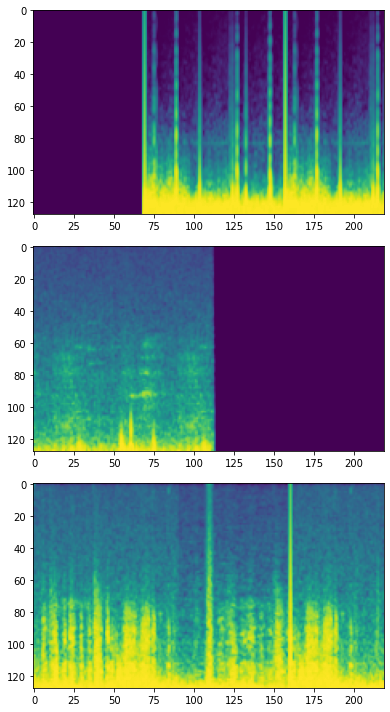

In [297]:
plt.figure(figsize=(10,10))
for idx in range(len(blank_clipped_aug[:3])):
    plt.subplot(3, 1, idx+1)
    plt.tight_layout()
    plt.imshow(blank_clipped_aug[idx])

In [286]:
blank_clipped = []
for idx in range(len(x_train)):
    audio_image = cv2.cvtColor(create_mel_raw(x_train[idx], sr, n_mels, f_min, f_max, nfft, hop, resz=3), cv2.COLOR_BGR2RGB)
    audio_raw_gray = cv2.cvtColor(create_mel_raw(x_train[idx], sr, n_mels, f_min, f_max, nfft, hop), cv2.COLOR_BGR2GRAY)

    audio_raw_gray[audio_raw_gray < 10] = 0
    for row in range(audio_raw_gray.shape[0]):
        black_percent = len(np.where(audio_raw_gray[row,:]==0)[0])/len(audio_raw_gray[row,:])
        if black_percent < 0.80:
            break

    if (row+1)*3 < audio_image.shape[0]:
        audio_image = audio_image[(row+1)*3:, :, :]
    audio_image = cv2.resize(audio_image, (audio_image.shape[1], n_mels*3), interpolation=cv2.INTER_LINEAR)
    audio_image, _, __ = cv2.split(audio_image)
    audio_image = cv2.resize(audio_image, (219, 128), interpolation=cv2.INTER_LINEAR)
    audio_image = np.array(audio_image, dtype=float)

    blank_clipped.append(audio_image)

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


In [288]:
def processed(signal, label):
    return signal, label

In [289]:
train_ar = []
for i in range(len(x_train)):
    blank_c = processed(blank_clipped[i], y_train[i])
    train_ar.append(blank_c)

In [299]:
for i in range(len(x_train)):
    blank_c_aug = processed(blank_clipped_aug[i], y_train[i])
    train_ar.append(blank_c_aug)

In [300]:
len(train_ar)

11036

In [302]:
train_ar[0]

(array([[ 72.,  41.,   0., ...,   0.,   0.,   0.],
        [ 72.,  41.,   0., ...,   0.,   0.,   0.],
        [ 74.,  42.,   0., ...,   0.,   0.,   0.],
        ...,
        [254., 254., 254., ..., 254., 254., 254.],
        [253., 253., 254., ..., 253., 253., 254.],
        [253., 253., 254., ..., 253., 253., 254.]]), 1)

## Time masking

returns a tensor of spectrogram

In [303]:
def time_mask(mel):
    prob = np.random.randint(0,2)
    if prob == 0:
        return tfio.audio.time_mask(mel, param=30)
    else:
        return tfio.audio.time_mask(mel, param=1)

In [304]:
masked = []
for idx in range(len(train_ar)):
    mask = time_mask(train_ar[idx][0])
    masked.append(mask)

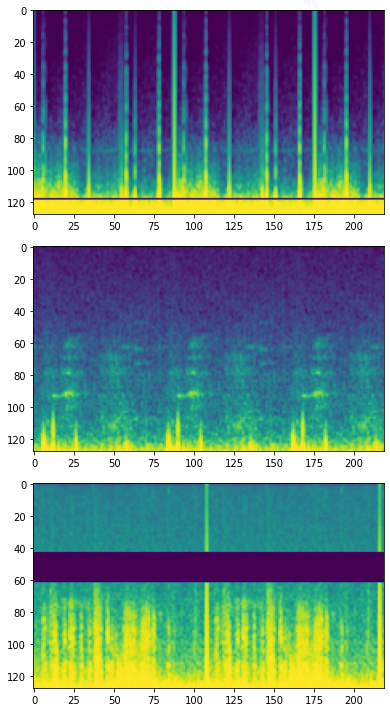

In [305]:
plt.figure(figsize=(10,10))
for idx in range(len(masked[:3])):
    plt.subplot(3, 1, idx+1)
    plt.tight_layout()
    plt.imshow(masked[idx])

In [326]:
new_train = []
for i in range(len(masked)):
    train = processed(masked[i], train_ar[i][1])
    new_train.append(train)

In [327]:
print('train datset count:', len(new_train))
print('x_train dataset type:', new_train[0][0].dtype)
print('y_train dataset type:', new_train[0][1].dtype)

train datset count: 11036
x_train dataset type: <dtype: 'float64'>
y_train dataset type: int64


In [328]:
x_train = []
y_train = []
for i in range(len(new_train)):
    x_train.append(new_train[i][0])
    y_train.append(new_train[i][1])

In [329]:
print(len(x_train))
print(len(y_train))

11036
11036


In [331]:
from collections import Counter

Counter(y_train)

Counter({0: 5826, 1: 2982, 2: 1418, 3: 810})

In [333]:
os.mkdir('/content/drive/MyDrive/hack/train_val_test')

In [364]:
with open('/content/drive/MyDrive/hack/train_val_test/x_train.pkl', 'wb') as f:
    pickle.dump(x_train, f)

In [365]:
with open('/content/drive/MyDrive/hack/train_val_test/y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)

In [366]:
with open('/content/drive/MyDrive/hack/train_val_test/x_val.pkl', 'wb') as f:
    pickle.dump(x_val, f)

In [367]:
with open('/content/drive/MyDrive/hack/train_val_test/y_val.pkl', 'wb') as f:
    pickle.dump(y_val, f)

In [368]:
with open('/content/drive/MyDrive/hack/train_val_test/x_test.pkl', 'wb') as f:
    pickle.dump(x_test, f)

In [369]:
with open('/content/drive/MyDrive/hack/train_val_test/y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)